**Titanic - Machine Learning from Disaster**

<div style="text-align: justify"> 
Source: https://www.kaggle.com/code/preejababu/titanic-data-science-solutions
</div>

***

# Import Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pathlib

# data analysis and wrangling
import pandas as pd
import numpy as np
from numpy import mean, std
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# tuning
from sklearn.model_selection import GridSearchCV

# visualization
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image  
from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus, graphviz

# machine learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score

In [2]:
# increase the display domain of dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Load Data

In [3]:
path_code = pathlib.Path().resolve()
# list((path_code).iterdir())
path_data = path_code / 'Data'

In [4]:
##### load titanic train data #####
df_train = pd.read_csv(path_data / 'train.csv')

print(df_train.shape)
df_train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
##### load titanic test data #####
df_test = pd.read_csv(path_data / 'test.csv')

print(df_test.shape)
df_test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
combine = [df_train, df_test]

# Data Preprocessing

## Exploratory Data Analysis 

In [7]:
# df_train.dtypes

In [8]:
# df_train.isna().sum()

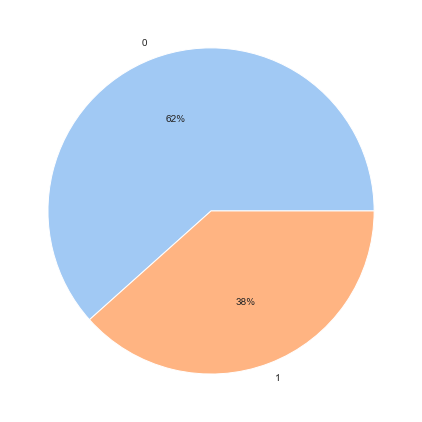

In [9]:
##### dependent factor: did the passenger survive or die? #####
# df_train.Survived.value_counts()

plt.figure(figsize=(7.5, 7.5))
colors = sns.color_palette('pastel')
plt.pie(x=list(df_train.Survived.value_counts().unique()), labels=list(df_train.Survived.unique()), 
        colors = colors, autopct='%.0f%%')
plt.show()

In [10]:
##### independent factors #####

In [11]:
##### catergorical factors #####
df_train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [12]:
##### Name --> Title #####
for dataset in combine:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(df_train.Title, df_train.Survived) 

Survived,0,1
Title,,
Capt,1,0
Col,1,1
Countess,0,1
Don,1,0
Dr,4,3
Jonkheer,1,0
Lady,0,1
Major,1,1
Master,17,23


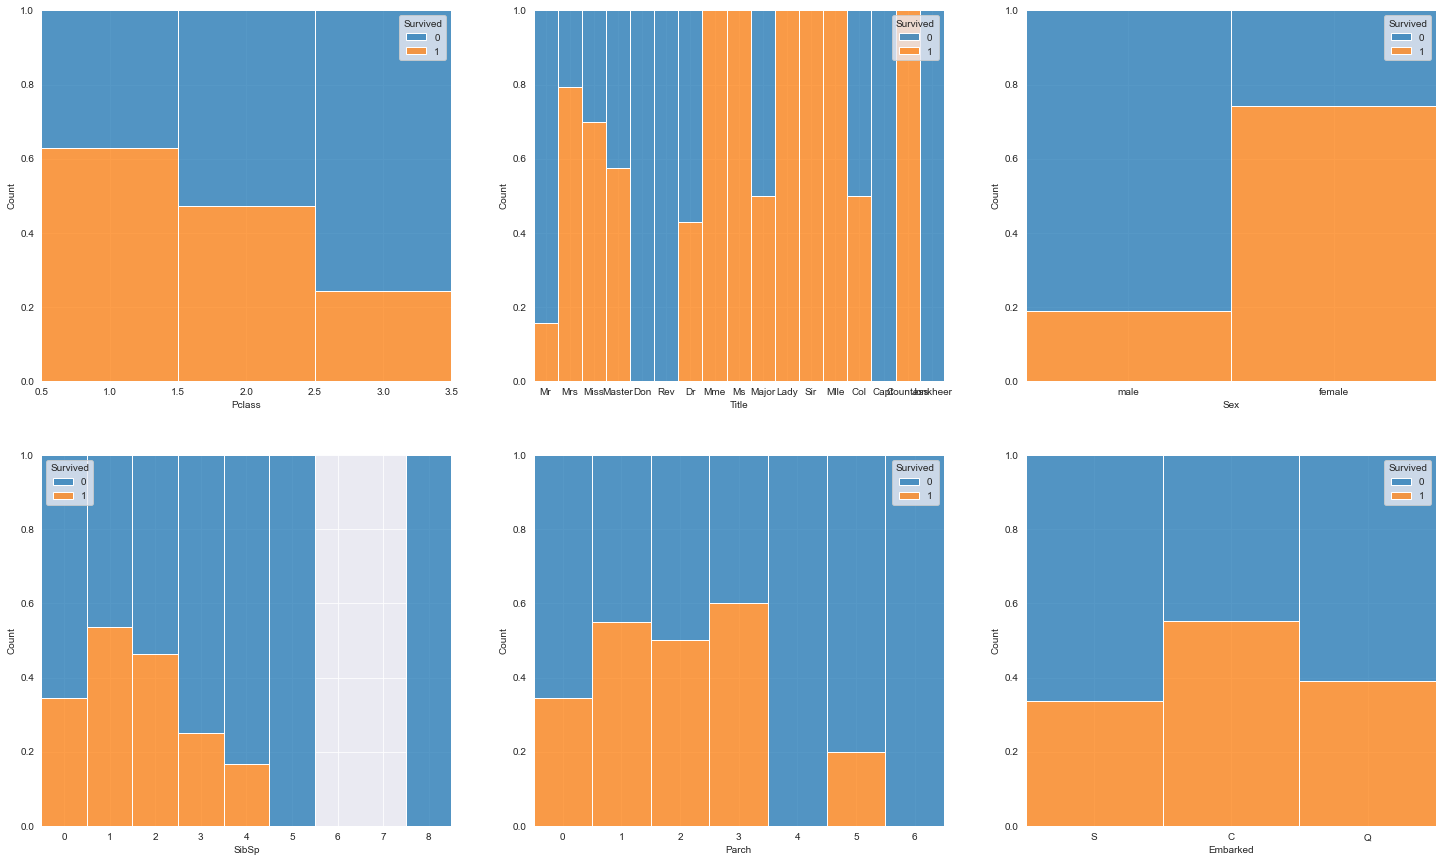

In [13]:
##### plot categorical factors #####
fig, axes = plt.subplots(2, 3, figsize=(25, 15))

categorical_factor = ['Pclass', 'Title', 'Sex', 'SibSp', 'Parch', 'Embarked']
for i, ax in zip(range(len(axes)), axes):
    for j, axis in zip(range(0, 3), ax):
        if i > 0: j += 3            

        sns.histplot(ax=axis, data=df_train, x=categorical_factor[j], hue='Survived',
                    multiple='fill', discrete=True)

In [14]:
##### numerical factors #####
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


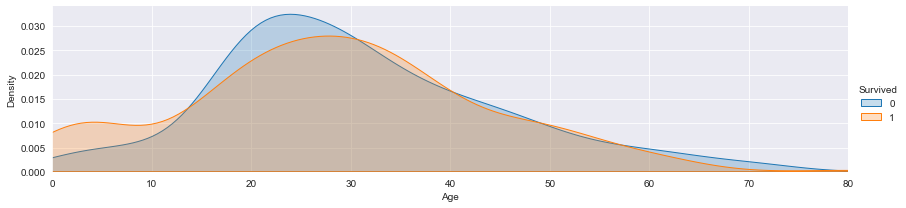

In [15]:
##### Age #####
facet = sns.FacetGrid(df_train, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, df_train['Age'].max()))
facet.add_legend() 
plt.show()

# children less than 10 mostly survived 

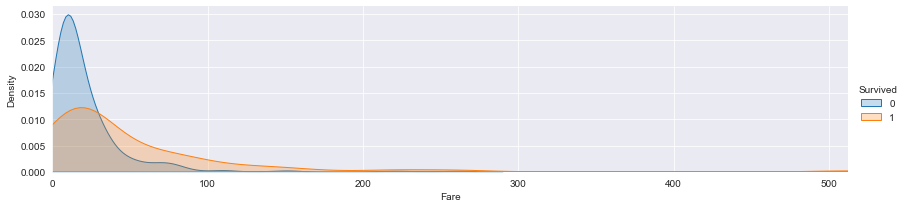

In [16]:
##### Fare #####
facet = sns.FacetGrid(df_train, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Fare', shade=True)
facet.set(xlim=(0, df_train['Fare'].max()))
facet.add_legend()
plt.show()

# very few passengers paid very high fare --> most survived

In [17]:
##### multivariate plot #####

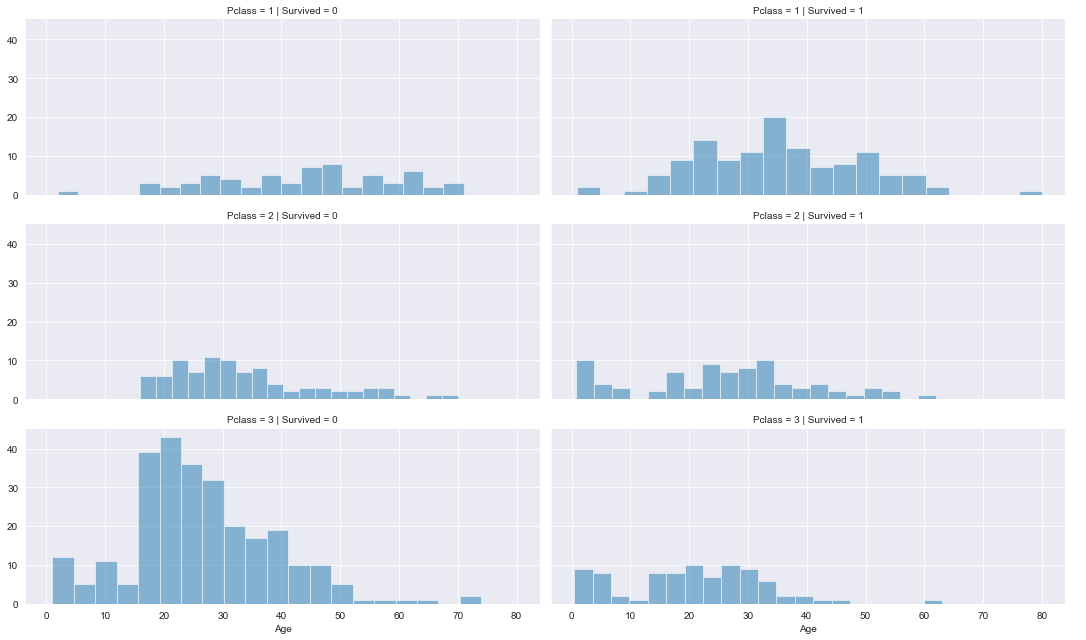

In [18]:
##### Pclass vs Age | Survived #####
grid = sns.FacetGrid(df_train, col='Survived', row='Pclass', aspect=2.5)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

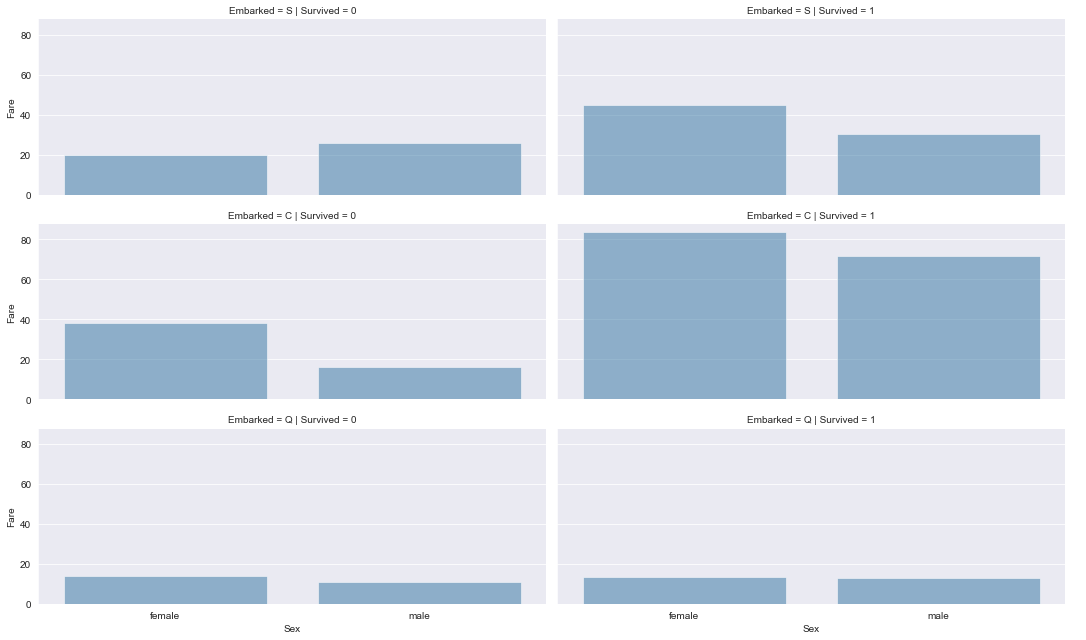

In [19]:
##### Embarked vs Sex | Survived #####
grid = sns.FacetGrid(df_train, row='Embarked', col='Survived', aspect=2.5)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, errorbar=None)
grid.add_legend()

## Feature Engineering

In [20]:
##### Embarked #####
for dataset in combine:
    dataset['Embarked'] =  dataset['Embarked'].fillna('S')

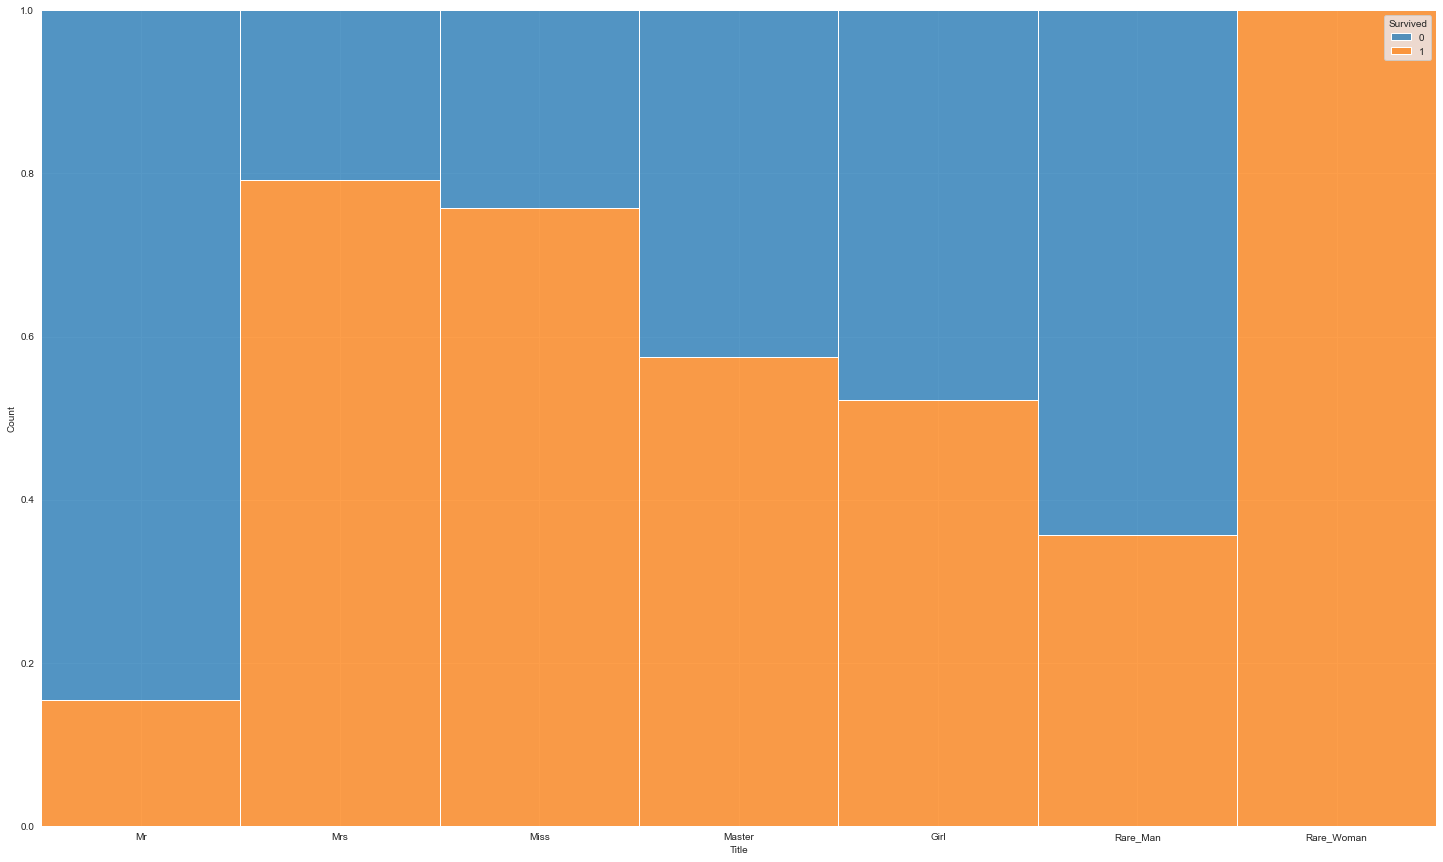

In [21]:
##### Title #####
# pd.crosstab(df_train.Title, df_train.Sex) # all title belongs to one kind of gender except doctor
# df_train[(df_train.Title=='Dr') & (df_train.Sex=='female')] # the PassengerId of the female 'Dr' is '797'

revised_title = {'Capt':'Rare_Man', 'Col':'Rare_Man', 'Don':'Rare_Man', 'Dona':'Rare_Woman', 'Dr':'Rare_Man', 'Jonkheer':'Rare_Man', 
                 'Lady':'Rare_Woman','Major':'Rare_Man', 'Master':'Master', 'Miss':'Miss', 'Mlle':'Rare_Woman', 'Mme':'Rare_Woman',
                 'Mr':'Mr', 'Mrs':'Mrs', 'Ms':'Rare_Woman', 'Rev':'Mr', 'Sir':'Rare_Man', 'Countess':'Rare_Woman'}

for dataset in combine:
    dataset['Title'] = dataset['Title'].map(revised_title)

df_train.loc[df_train.PassengerId==797, 'Title'] = 'Rare_Woman' 

# df_train[['Title', 'Age']].groupby(['Title']).agg({'Age': ['mean', 'min', 'max']})

# 'Master' mainly stands for little boy, but we also want to find little girl. Because children tend to have higher survival rate.
# for the 'Miss' with a Age record, we can simply determine whether a 'Miss' is a little girl by her age.
# for the 'Miss' with no Age record, we use (Parch != 0). Since if it's a little girl, she was very likely to be accompanied by parents.

def girl(df):
    if (not (np.isnan(df.Age))) & (df.Title == 'Miss') & (df.Age <= 14):
        return 'Girl'
    elif (np.isnan(df.Age)) & (df.Title == 'Miss') & (df.Parch != 0):
        return 'Girl'
    else:
        return df.Title

for dataset in combine:
    dataset['Title'] = dataset.apply(girl, axis=1)

title = ['Mr', 'Miss', 'Mrs', 'Master', 'Girl', 'Rare_Man', 'Rare_Woman']
for dataset in combine:
    for i in title:
        dataset.loc[(np.isnan(dataset.Age)) & (dataset.Title==i), 'Age'] = dataset.loc[dataset.Title == i, 'Age'].median()

# df_train.Title.isna().sum()

plt.figure(figsize=(25, 15))
sns.histplot(data=df_train, x='Title', hue='Survived', multiple='fill', discrete=True)
# df_train.groupby(['Title'])[['Age', 'Title']].mean().plot(kind='bar')
plt.show()

In [22]:
##### Age #####
df_train['FareCut'] = pd.NaT
df_test['FareCut'] = pd.NaT

for dataset in combine:
    dataset.loc[(dataset.Age <= 15, 'AgeCut')] = 1
    dataset.loc[(dataset.Age > 15) & (dataset.Age <= 30), 'AgeCut'] = 2
    dataset.loc[(dataset.Age > 30) & (dataset.Age <= 50), 'AgeCut'] = 3
    dataset.loc[(dataset.Age > 50) & (dataset.Age <= 65), 'AgeCut'] = 4
    dataset.loc[(dataset.Age > 65, 'AgeCut')] = 5

# df_train.AgeCut.value_counts().sort_index()

<AxesSubplot: xlabel='FareCut'>

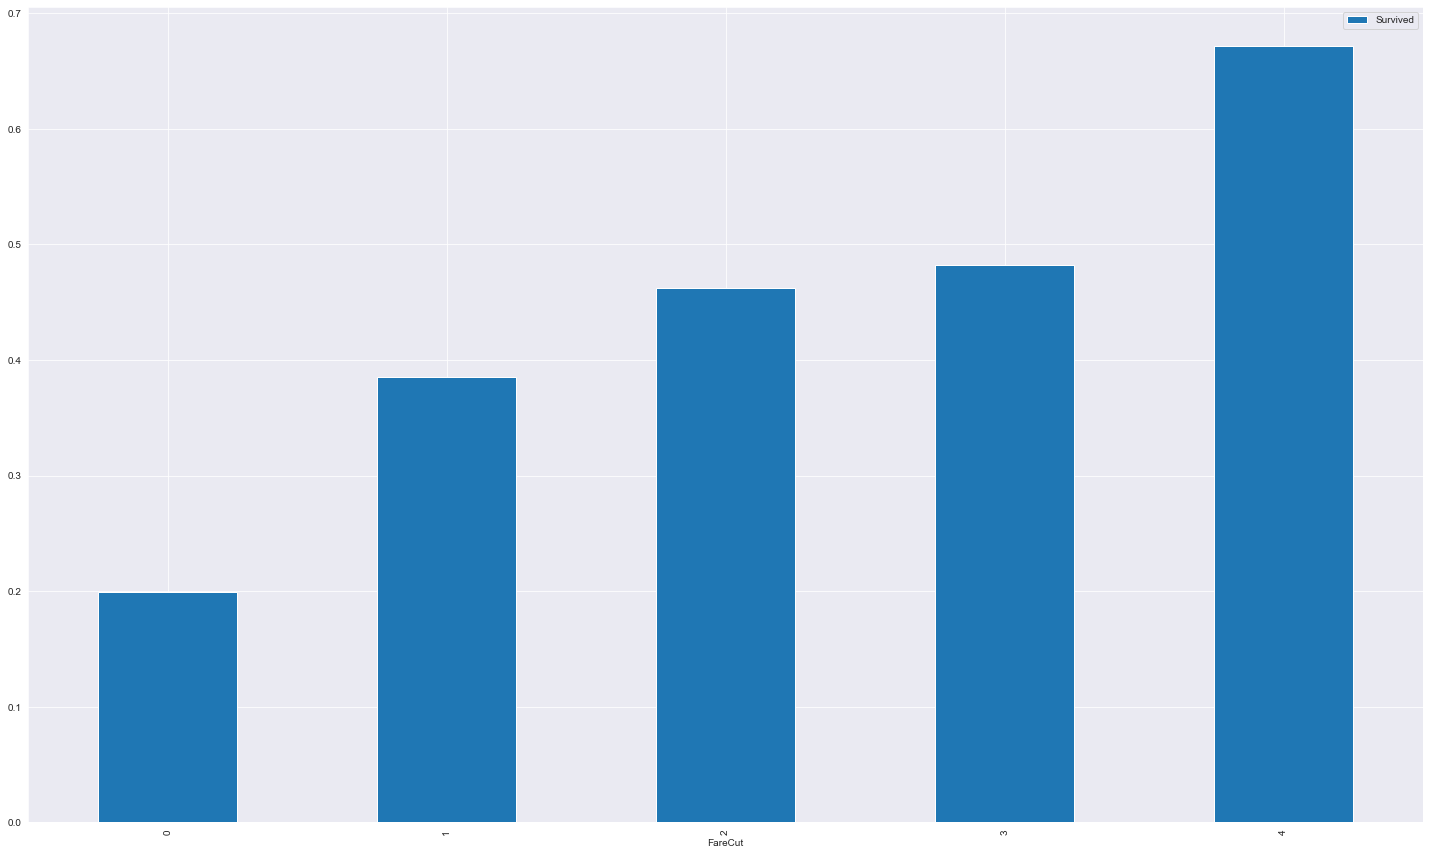

In [23]:
##### Fare #####
# df_test.Fare.isna().sum()
df_test['Fare'].fillna(df_test['Fare'].dropna().median(), inplace=True)

df_train['FareCut'] = pd.NaT
df_test['FareCut'] = pd.NaT

for dataset in combine:
    dataset.loc[(dataset.Fare <= 10, 'FareCut')] = 0
    dataset.loc[(dataset.Fare > 10) & (dataset.Fare <= 15), 'FareCut'] = 1
    dataset.loc[(dataset.Fare > 15) & (dataset.Fare <= 30), 'FareCut'] = 2
    dataset.loc[(dataset.Fare > 30) & (dataset.Fare <= 60), 'FareCut'] = 3
    dataset.loc[(dataset.Fare > 60, 'FareCut')] = 4
    
df_train[['FareCut','Survived']].groupby(['FareCut']).mean().plot.bar(figsize=(25, 15))

In [24]:
# df_train.head()
for dataset in combine:
    dataset.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True)
    dataset['AgeCut'] = dataset['AgeCut'].astype(int)

In [25]:
##### one-hot encoding #####
df_names = ['df_train', 'df_test']
dict_dataframe = {}

for i in range(len(combine)):
    dict_dataframe[df_names[i]] = pd.get_dummies(data=combine[i], 
                                                 columns=['Pclass', 'Sex', 'Embarked', 'Title', 'FareCut', 'AgeCut'], 
                                                 drop_first=True)

df_train = dict_dataframe['df_train']
df_test = dict_dataframe['df_test']
combine = [df_train, df_test]

In [26]:
##### Cabin #####
for dataset in combine:
    dataset['Cabin'] = dataset['Cabin'].str[:1]
    
# df_train.Cabin.value_counts()
    
cabin_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7}
for dataset in combine:
    dataset['Cabin'] = dataset['Cabin'].map(cabin_mapping)

In [27]:
##### imputation #####
df_names = ['df_train', 'df_test']
dict_dataframe = {}

knn_imputer = KNNImputer(n_neighbors=3)

for i in range(len(combine)):
    dict_dataframe[df_names[i]] = knn_imputer.fit_transform(combine[i])

df_train = pd.DataFrame(dict_dataframe['df_train'], columns=df_train.columns)
df_test = pd.DataFrame(dict_dataframe['df_test'], columns=df_test.columns)
combine = [df_train, df_test]

df_train.Cabin = round(df_train.Cabin)
df_test.Cabin = round(df_test.Cabin)

In [28]:
df_train.head()

,Survived,Age,SibSp,Parch,Fare,Cabin,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare_Man,Title_Rare_Woman,FareCut_1,FareCut_2,FareCut_3,FareCut_4,AgeCut_2,AgeCut_3,AgeCut_4,AgeCut_5
0,0.0,22.0,1.0,0.0,7.2500,5.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,38.0,1.0,0.0,71.2833,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.0,26.0,0.0,0.0,7.9250,5.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,35.0,1.0,0.0,53.1000,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,35.0,0.0,0.0,8.0500,3.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [29]:
X_train = df_train.drop('Survived', axis=1)
y_train = df_train['Survived']
X_test = df_test

X_train.shape, y_train.shape, X_test.shape

((891, 24), (891,), (418, 24))

In [30]:
# ##### scale data #####
# scaler = StandardScaler()

# X_train_SCALED = pd.DataFrame(scaler.fit(X_train).transform(X_train), columns=X_train.columns)
# X_test_SCALED = pd.DataFrame(scaler.fit(X_test).transform(X_test), columns=X_test.columns)

# Modeling

## Decision Tree

In [31]:
##### tune hyperparameters ######
param_grid = {'max_depth': range(0, 15, 1),
              'min_samples_leaf': range(0, 100, 10),
              'min_samples_split': range(0, 100, 10),
              'criterion': ['gini', 'entropy']
             }

tune_dtree = DecisionTreeClassifier(random_state=906)
grid_search = GridSearchCV(estimator=tune_dtree,
                          param_grid=param_grid,
                          cv=5,
                          verbose=1,
                          n_jobs=-1)

dtree_grid_result = grid_search.fit(X_train, y_train)

print('Best: %f using %s' % (dtree_grid_result.best_score_, dtree_grid_result.best_params_))

Fitting 5 folds for each of 3000 candidates, totalling 15000 fits
Best: 0.835001 using {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 10}


In [32]:
##### fit decision tree model with optimal hyperparamters #####
clf_dtree = DecisionTreeClassifier(criterion='gini',
                                   max_depth=4,
                                   min_samples_leaf=10,
                                   min_samples_split=10, 
                                   random_state=906)

clf_dtree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, min_samples_split=10,
                       random_state=906)

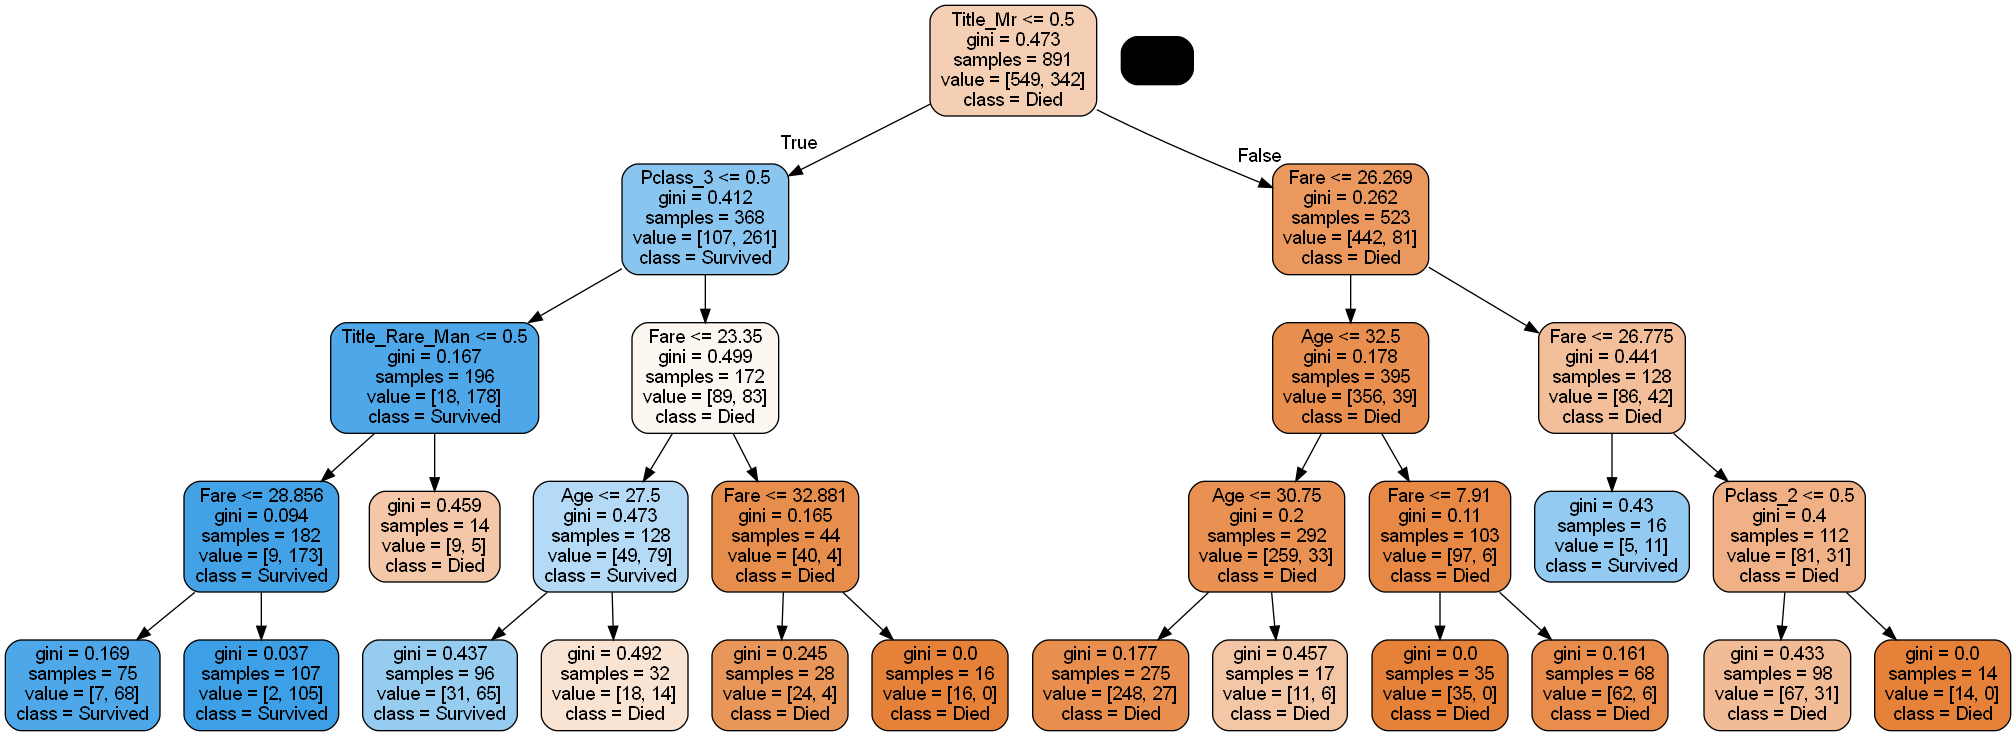

In [33]:
##### plot decision tree #####
dot_data = StringIO()  

export_graphviz(clf_dtree, out_file=dot_data, filled=True, rounded=True,
                feature_names=X_train.columns, 
                class_names=['Died', 'Survived'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png(r'C:\Users\Asus\Codebase\Python\Jupyter\ucf-class-projects\Spring 2023\CAP5610_Machine Learning\Homework\HW2\Output\dtree.png')

Image(graph.create_png())

In [34]:
##### apply five-fold cross validation on fine-tuned decision tree #####
clf_dtree = DecisionTreeClassifier(criterion='gini',                                   
                                   max_depth=4,
                                   min_samples_leaf=10,
                                   min_samples_split=10,
                                   random_state=906)

cv = KFold(n_splits=5, random_state=906, shuffle=True)
scores = cross_val_score(clf_dtree, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.826 (0.030)


## Random Forest

In [35]:
##### tune hyperparameters ######
param_grid = {'n_estimators': range(0, 150, 10),
              'criterion': ['gini','entropy', 'log_loss'],
              'max_depth': range(0, 15, 1),
              'max_features': ['sqrt', 'log2']
             }

tune_rf_classifier = RandomForestClassifier(random_state=906)
grid_search = GridSearchCV(estimator=tune_rf_classifier,
                           param_grid=param_grid,
                           cv=5,
                           verbose=1, 
                           n_jobs=-1)

rf_classifier_grid_result = grid_search.fit(X_train, y_train)

print('Best: %f using %s' % (rf_classifier_grid_result.best_score_, rf_classifier_grid_result.best_params_))

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits
Best: 0.835032 using {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 30}


In [36]:
##### apply five-fold cross validation on fine-tuned random forest #####
rf_classifier = RandomForestClassifier(n_estimators=30,
                                       criterion='gini',
                                       max_depth=10,
                                       max_features='sqrt',
                                       random_state=906)
                                   
cv = KFold(n_splits=5, random_state=906, shuffle=True)
scores = cross_val_score(rf_classifier, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.833 (0.019)
